In [21]:
import numpy as np
import pandas as pd
import keras
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Utils Functions ===
def dm2comp(dm):
    '''Extract weights and vectors from a density matrix.'''
    return dm[:, :, 0], dm[:, :, 1:]

def pure2dm(psi):
    '''Construct a pure-state density matrix from feature vectors.'''
    ones = keras.ops.ones_like(psi[:, 0:1])
    dm = keras.ops.concatenate((ones[:, np.newaxis, :], psi[:, np.newaxis, :]), axis=2)
    return dm

def dm_rbf_loglik(x, dm, sigma):
    '''Log-likelihood under an RBF-kernel density matrix.'''
    d = keras.ops.shape(x)[-1]
    w, v = dm2comp(dm)
    dist = keras.ops.sum((x[:, np.newaxis, :] - v) ** 2, axis=-1)
    ll = keras.ops.log(
        keras.ops.einsum('...i,...i->...', w,
                         keras.ops.exp(-dist / (2 * sigma ** 2)) ** 2)
        + 1e-12
    )
    coeff = d * keras.ops.log(sigma + 1e-12) + d * np.log(np.pi) / 2
    return ll - coeff

def dm_rbf_expectation(dm):
    '''Expectation under an RBF-kernel density matrix.'''
    w, v = dm2comp(dm)
    return keras.ops.einsum('...i,...ij->...j', w, v)

def dm_rbf_variance(dm, sigma):
    '''Variance (trace) under an RBF-kernel density matrix.'''
    sigma_adj = sigma / keras.ops.sqrt(2)
    w, v = dm2comp(dm)
    d = keras.ops.shape(v)[-1]
    squared_norms = keras.ops.sum(v ** 2, axis=-1)
    weighted_sq = keras.ops.einsum('...i,...i->...', w, squared_norms)
    means = keras.ops.einsum('...i,...ij->...j', w, v)
    sq_means = keras.ops.sum(means ** 2, axis=-1)
    between = weighted_sq - sq_means
    return between + d * (sigma_adj ** 2)

def gauss_entropy_lb(d, sigma):
    '''Lower bound on entropy of a Gaussian mixture.'''
    return (d / 2.0) * (1.0 + keras.ops.log(2.0 * np.pi * (sigma ** 2)))

def l1_loss(vals):
    '''L1 regularization over normalized activations or components.'''
    b_size = keras.ops.cast(keras.ops.shape(vals)[0], dtype=keras.float32)
    vals_norm = keras.utils.normalize(vals, order=2, axis=1)
    return keras.ops.sum(keras.ops.abs(vals_norm)) / b_size



In [22]:
# === Kernel Layers ===
class RBFKernelLayer(keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.sigma = self.add_weight(
            shape=(), initializer=keras.initializers.Constant(value=sigma), trainable=trainable
        )
        self.dim = dim
        self.min_sigma = min_sigma

    def call(self, A, B):
        shape_A = keras.ops.shape(A)
        A_norm = keras.ops.sum(A**2, axis=-1)[..., np.newaxis]
        B_norm = keras.ops.sum(B**2, axis=-1)[np.newaxis, np.newaxis, :]
        A_flat = keras.ops.reshape(A, [-1, shape_A[2]])
        AB = keras.ops.matmul(A_flat, keras.ops.transpose(B))
        AB = keras.ops.reshape(AB, [shape_A[0], shape_A[1], keras.ops.shape(B)[0]])
        dist2 = keras.ops.clip(A_norm + B_norm - 2.*AB, 0., np.inf)
        self.sigma.assign(keras.ops.clip(self.sigma, self.min_sigma, np.inf))
        return keras.ops.exp(-dist2 / (2.*self.sigma**2))

    def log_weight(self):
        sigma_c = keras.ops.clip(self.sigma, self.min_sigma, np.inf)
        return -self.dim * keras.ops.log(sigma_c + 1e-12) - self.dim * np.log(4 * np.pi)

class KDMLayer(keras.layers.Layer):
    def __init__(self, kernel, dim_x, dim_y, x_train=True, y_train=True, w_train=True,
                 n_comp=0, l1_x=0., l1_y=0., l1_act=0., generative=0., **kwargs):
        super().__init__(**kwargs)
        self.kernel, self.dim_x, self.dim_y = kernel, dim_x, dim_y
        self.x_train, self.y_train, self.w_train = x_train, y_train, w_train
        self.n_comp, self.l1_x, self.l1_y, self.l1_act, self.generative = (
            n_comp, l1_x, l1_y, l1_act, generative
        )
        self.c_x = self.add_weight(
            shape=(n_comp, dim_x), initializer=keras.initializers.random_normal(),
            trainable=x_train, name="c_x"
        )
        self.c_y = self.add_weight(
            shape=(n_comp, dim_y),
            initializer=keras.initializers.Constant(np.sqrt(1./dim_y)),
            trainable=y_train, name="c_y"
        )
        self.c_w = self.add_weight(
            shape=(n_comp,),
            initializer=keras.initializers.constant(1./n_comp),
            trainable=w_train, name="c_w"
        )
        self.eps = 1e-12

    def call(self, inputs):
        if self.l1_x:
            self.add_loss(self.l1_x * l1_loss(self.c_x))
        if self.l1_y:
            self.add_loss(self.l1_y * l1_loss(self.c_y))
        cw = keras.ops.abs(self.c_w)
        cw_sum = keras.ops.clip(keras.ops.sum(cw), self.eps, np.inf)
        self.c_w.assign(cw / cw_sum)

        in_w = inputs[..., 0]
        in_v = inputs[..., 1:]
        out_vw = self.kernel(in_v, self.c_x)
        out_w = cw[np.newaxis, np.newaxis, :] * keras.ops.square(out_vw)

        if self.generative:
            proj = keras.ops.einsum('...i,...ij->...', in_w, out_w)
            logp = keras.ops.log(proj + self.eps) + self.kernel.log_weight()
            self.add_loss(-self.generative * keras.ops.mean(logp))

        out_w = keras.ops.maximum(out_w, self.eps)
        out_w = out_w / keras.ops.sum(out_w, axis=2, keepdims=True)
        out_w = keras.ops.einsum('...i,...ij->...j', in_w, out_w)

        if self.l1_act:
            self.add_loss(self.l1_act * l1_loss(out_w))

        out_w = out_w[..., np.newaxis]
        b = keras.ops.shape(out_w)[0]
        out_y = keras.ops.broadcast_to(self.c_y[np.newaxis, ...], [b, self.n_comp, self.dim_y])
        return keras.ops.concatenate((out_w, out_y), axis=2)

    def get_config(self):
        base = super().get_config()
        return {**base, 'dim_x': self.dim_x, 'dim_y': self.dim_y, 'n_comp': self.n_comp}

class KDMRegressModel(keras.Model):
    def __init__(self, encoded_size, dim_y, encoder, n_comp,
                 sigma_x=0.1, min_sigma_x=1e-3,
                 sigma_y=0.1, min_sigma_y=1e-3,
                 x_train=True, y_train=True, w_train=True,
                 generative=0., entropy_reg_x=0.,
                 sigma_x_trainable=True, sigma_y_trainable=True,
                 **kwargs):
        super().__init__(**kwargs)
        self.dim_y, self.encoded_size, self.n_comp = dim_y, encoded_size, n_comp
        self.encoder, self.entropy_reg_x = encoder, entropy_reg_x
        if generative > 0:
            self.encoder.trainable = False

        self.kernel = RBFKernelLayer(sigma_x, encoded_size,
                                     trainable=sigma_x_trainable,
                                     min_sigma=min_sigma_x)
        self.kdm = KDMLayer(self.kernel, encoded_size, dim_y,
                             x_train=x_train, y_train=y_train, w_train=w_train,
                             n_comp=n_comp, generative=generative)
        self.sigma_y = self.add_weight(
            shape=(), initializer=keras.initializers.constant(sigma_y),
            trainable=sigma_y_trainable, name="sigma_y"
        )
        self.min_sigma_y = min_sigma_y

    def call(self, inputs):
        rho_x = pure2dm(self.encoder(inputs))
        rho_y = self.kdm(rho_x)
        self.sigma_y.assign(keras.ops.clip(self.sigma_y, self.min_sigma_y, np.inf))
        return rho_y

    def predict_reg(self, inputs, **kwargs):
        rho_y = self.predict(inputs, **kwargs)
        y_exp = keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y))
        y_var = keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, self.sigma_y))
        return y_exp, y_var

    def get_sigmas(self):
        return keras.ops.convert_to_numpy(self.kernel.sigma), keras.ops.convert_to_numpy(self.sigma_y)

    def loglik(self, y_true, y_pred):
        return -keras.ops.mean(dm_rbf_loglik(y_true, y_pred, self.sigma_y))

    def init_components(self, samples_x, samples_y, init_sigma=False, sigma_mult=1):
        enc = self.encoder.predict(samples_x)
        if init_sigma:
            np_enc = keras.ops.convert_to_numpy(enc)
            d, _ = NearestNeighbors(n_neighbors=3).fit(np_enc).kneighbors(np_enc)
            self.kernel.sigma.assign(np.mean(d[:, 2]) * sigma_mult)
        self.kdm.c_x.assign(enc)
        self.kdm.c_y.assign(samples_y)
        self.kdm.c_w.assign(keras.ops.ones((self.n_comp,)) / self.n_comp)



In [23]:
# === Data Loading: Boston Housing ===
data = pd.read_csv('/content/housing.txt', header=None, sep=r'\s+')
arr = data.to_numpy()
X = arr[:, :-1]
y = arr[:, -1].reshape(-1, 1)

# Standardize
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

# Split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [24]:
# === Model Setup ===
encoder = keras.Sequential([keras.layers.Identity()])
n_comp = 180
model = KDMRegressModel(
    encoded_size=x_train.shape[1],
    dim_y=y_train.shape[1],
    encoder=encoder,
    n_comp=n_comp,
    sigma_x=0.2,
    min_sigma_x=1e-3,
    sigma_y=0.3,
    min_sigma_y=0.15,
    generative=1.0,
    sigma_x_trainable=False,
    sigma_y_trainable=True
)

# Compile with the custom loss
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-3),
    loss=model.loglik
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Init components and train
idx = np.random.RandomState(42).randint(x_train.shape[0], size=n_comp)
model.init_components(x_train[idx], y_train[idx], init_sigma=True)

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 38.8037 - val_loss: 39.2390
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.6843 - val_loss: 38.8711
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.3425 - val_loss: 38.6807
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.1314 - val_loss: 38.6396
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 38.3495 - val_loss: 38.6278
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.1204 - val_loss: 38.6007
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.2622 - val_loss: 38.5638
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.2441 - val_loss: 38.5356
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37.9347 - val_loss: 38.5403
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.0051 - val_loss: 38.5073
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.2445 - val_loss: 38.501

In [25]:
# === Metrics & Sigmas ===
sigma_x, sigma_y = model.get_sigmas()
y_pred, y_var = model.predict_reg(x_test)
y_pred_res = sc_y.inverse_transform(y_pred)
y_test_res = sc_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_res, y_pred_res)
r2 = r2_score(y_test_res, y_pred_res)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")
print(f"Sigma_x learned: {sigma_x:.4f}")
print(f"Sigma_y learned: {sigma_y:.4f}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Test MSE: 0.2421
Test R²: 0.7690
Sigma_x learned: 1.1460
Sigma_y learned: 0.1500


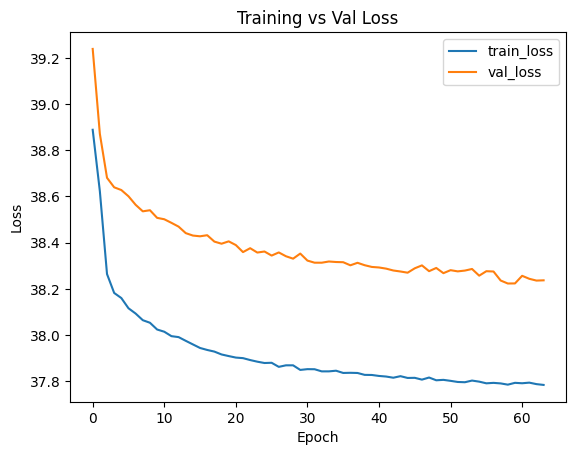

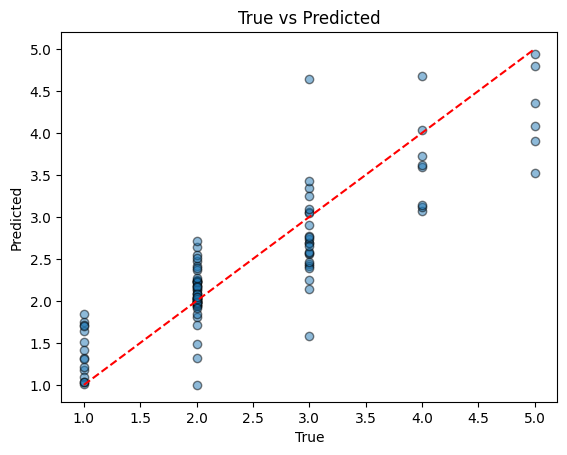

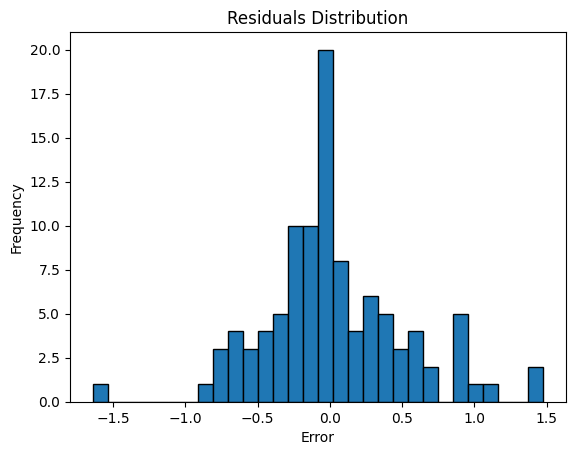

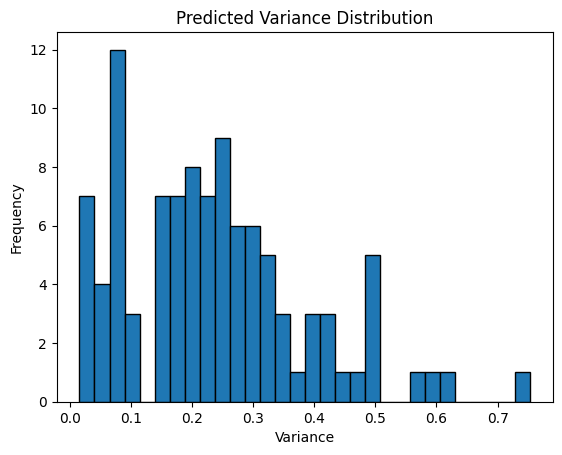

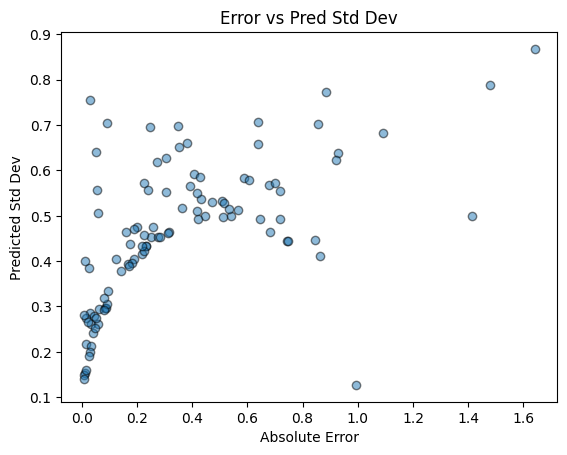

In [26]:
# === Plots ===
# Loss curves
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Val Loss'); plt.legend(); plt.show()

# True vs Predicted
plt.figure()
plt.scatter(y_test_res, y_pred_res, alpha=0.5, edgecolor='k')
lims = [y_test_res.min(), y_test_res.max()]
plt.plot(lims, lims, 'r--')
plt.xlabel('True'); plt.ylabel('Predicted'); plt.title('True vs Predicted'); plt.show()

# Residuals histogram
res = y_test_res - y_pred_res
plt.figure()
plt.hist(res.flatten(), bins=30, edgecolor='k')
plt.title('Residuals Distribution'); plt.xlabel('Error'); plt.ylabel('Frequency'); plt.show()

# Predicted variance histogram
plt.figure()
plt.hist(y_var.flatten(), bins=30, edgecolor='k')
plt.title('Predicted Variance Distribution'); plt.xlabel('Variance'); plt.ylabel('Frequency'); plt.show()

# Error vs Pred Std Dev
plt.figure()
plt.scatter(np.abs(res.flatten()), np.sqrt(y_var.flatten()), alpha=0.5, edgecolor='k')
plt.xlabel('Absolute Error'); plt.ylabel('Predicted Std Dev')
plt.title('Error vs Pred Std Dev'); plt.show()
